# Introduction

In [ ]:
"""
What? Adversaeial example in pytorch

You may be surprised to find that adding imperceptible perturbations to an image can cause drastically different
model performance. Specifically we will use one of the first and most popular attack methods, the Fast Gradient 
Sign Attack (FGSM), to fool an MNIST classifier.
"""

# Import python modules

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Inputs

In [ ]:
"""
epsilon = List of epsilon values to use for the run. It is important to keep 0 in the list because it represents 
the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more
noticeable the perturbations but the more effective the attack in terms of degrading model accuracy
"""

In [4]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./lenet_mnist_model.pth"
use_cuda=False

# Model Under Attack

In [ ]:
"""
The model under attack is the same MNIST. The purpose of this section is to define the model and dataloader, 
then initialize the model and load the pretrained weights.
"""

In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)



In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# FGSM Attack

In [ ]:
"""
Now, we can define the function that creates the adversarial examples by perturbing the original inputs. 
The fgsm_attack function takes three inputs, image is the original clean image (x), epsilon is the pixel-wise
perturbation amount (ϵ), and data_grad is gradient of the loss w.r.t the input image. Finally, in order to 
maintain the original range of the data, the perturbed image is clipped to range [0,1].
"""

In [8]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# Testing function

In [ ]:
"""
Finally, the central result of this tutorial comes from the test function. Each call to this test function 
performs a full test step on the MNIST test set and reports a final accuracy. However, notice that this 
function also takes an epsilon input. This is because the test function reports the accuracy of a model that
is under attack from an adversary with strength ϵ. More specifically, for each sample in the test set, the 
function computes the gradient of the loss w.r.t the input data (data_grad), creates a perturbed image with 
fgsm_attack (perturbed_data), then checks to see if the perturbed example is adversarial. In addition to 
testing the accuracy of the model, the function also saves and returns some successful adversarial examples 
to be visualized later.
"""

In [9]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

# Run Attack

In [ ]:
"""
The last part of the implementation is to actually run the attack. Here, we run a full test step for each
epsilon value in the epsilons input. For each epsilon we also save the final accuracy and some successful 
adversarial examples to be plotted in the coming sections. Notice how the printed accuracies decrease as 
the epsilon value increases. Also, note the ϵ=0 case represents the original test accuracy, with no attack.
"""

In [10]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


# Accuracy vs Epsilon

In [ ]:
"""
The first result is the accuracy versus epsilon plot. As alluded to earlier, as epsilon increases we expect 
the test accuracy to decrease. This is because larger epsilons mean we take a larger step in the direction 
that will maximize the loss. Notice the trend in the curve is not linear even though the epsilon values are 
linearly spaced.

Also, notice the accuracy of the model hits random accuracy for a 10-class classifier between ϵ=0.25 and ϵ=0.3.
A random accuracy is the on at 50%!
"""

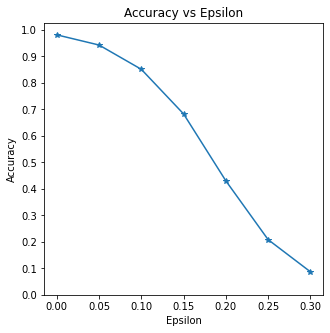

In [11]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Sample Adversarial Examples

In [ ]:
"""
In this case, as epsilon increases the test accuracy decreases BUT the perturbations become more easily perceptible.
The title of each image shows the “original classification -> adversarial classification.” Notice, the perturbations 
start to become evident at ϵ=0.15 and are quite evident at ϵ=0.3. However, in all cases humans are still capable of 
identifying the correct class despite the added noise.
"""

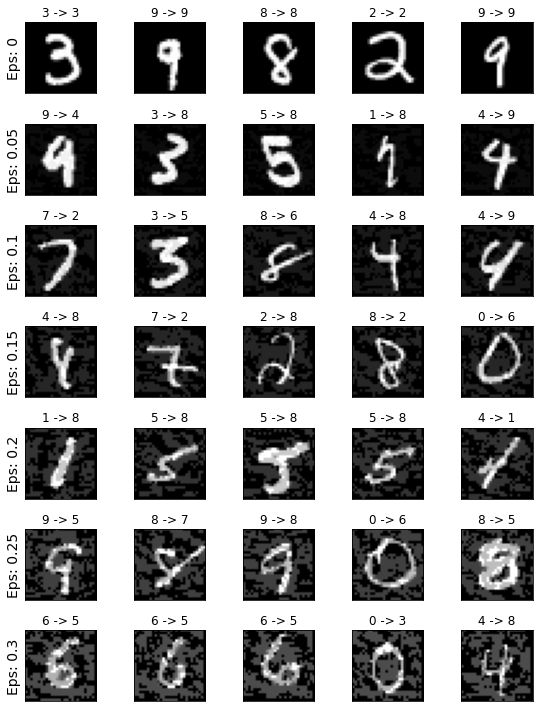

In [12]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
"""
This attack represents the very beginning of adversarial attack research and since there have been many subsequent
ideas for how to attack and DEFEND ML models from an adversary. 
"""

# References

<div class="alert alert-warning">
<font color=black>

- https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
- https://arxiv.org/pdf/1804.00097.pdf

</font>
</div>